**1. Import dependencies**

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os, shutil
from keras.layers import Dropout

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
keras.__version__

Using TensorFlow backend.


'2.3.1'

**2. Create data generators**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
generated_Images='new_bottels'
if not os.path.exists(generated_Images):
    os.mkdir(generated_Images)
    print('Created directory: ', generated_Images)

for i in os.listdir('/content/drive/My Drive/data_bottels') :
  image_path='/content/drive/My Drive/data_bottels/'+i
  for j in os.listdir(image_path):
    print(j)
    dir_categ='/content/new_bottels/'+i
    if not os.path.exists(dir_categ):
      os.mkdir(dir_categ)
      print('Created directory: ', i)

    img = load_img('/content/drive/My Drive/data_bottels/'+i+'/'+j)  
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape)  


    k = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=dir_categ, save_prefix='_new_data_'+i, save_format='jpeg'):
        k += 1
        if k > 30:
            break  

In [ ]:
def plot_imgs(item_dir, top=3):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:3]
  
    plt.figure(figsize=(18,18))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

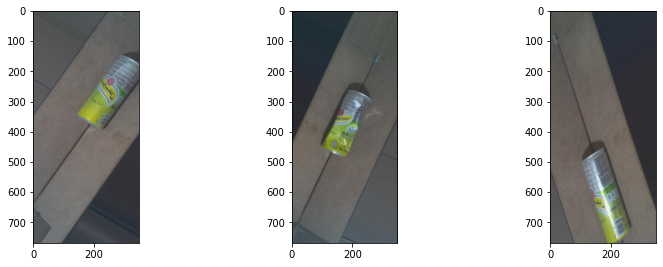

In [ ]:
plot_imgs(generated_Images+'/can0.25l')

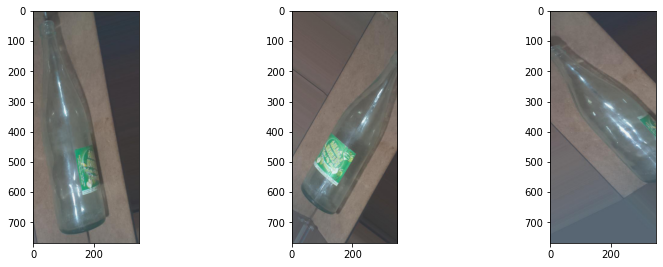

In [ ]:
plot_imgs(generated_Images+'/glass1l')

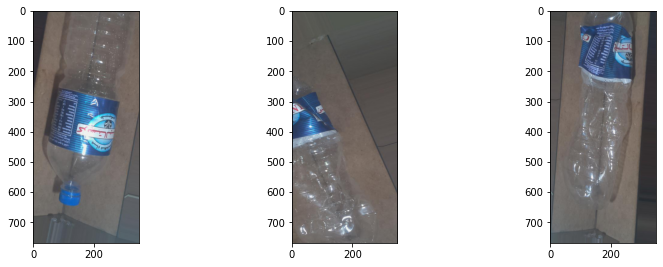

In [ ]:
plot_imgs(generated_Images+'/plastic2l')

**3. Split data into train and validation**

In [ ]:
base_dir = 'data'
categories = ['can0.3l', 'can0.25l','glass1l','plastic0.3l','plastic0.5l','plastic1.5l','plastic1l','plastic2l']

In [ ]:

# We want to keep our data organized into train and validation folders, each with separate category subfolders
str_train_val = ['train', 'validation']

if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    print('Created directory: ', base_dir)

for dir_type in str_train_val:
    train_test_val_dir = os.path.join(base_dir, dir_type)

    if not os.path.exists(train_test_val_dir):
        os.mkdir(train_test_val_dir)

    for category in categories:
        dir_type_category = os.path.join(train_test_val_dir, category)

        if not os.path.exists(dir_type_category):
            os.mkdir(dir_type_category)
            print('Created directory: ', dir_type_category)

In [ ]:
original_dataset_dir = '/content/new_bottels'
directories_dict = {}  
np.random.seed(12)
for cat in categories:
    list_of_images = np.array(os.listdir(os.path.join(original_dataset_dir,cat)))
    print("{}: {} files".format(cat, len(list_of_images)))
    indexes = dict()
    indexes['validation'] = sorted(np.random.choice(len(list_of_images), size=int(len(list_of_images)*0.2), replace=True))
    indexes['train'] = list(set(range(len(list_of_images))) - set(indexes['validation']))
    for phase in str_train_val:
        for i, fname in enumerate(list_of_images[indexes[phase]]):
            source = os.path.join(original_dataset_dir, cat, fname)
            destination = os.path.join(base_dir, phase, cat, str(i)+".jpg")
            shutil.copyfile(source, destination)
        print("{}, {}: {} files copied".format(cat, phase, len(indexes[phase])))
        directories_dict[phase + "_" + cat + "_dir"] = os.path.join(base_dir, phase, cat)

In [ ]:


train_generator = datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))

Found 10372 images belonging to 8 classes.
Found 2531 images belonging to 8 classes.


In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'\\Plastic'):
    
    img = imread(train_path+'\\Plastic'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

**3. Create the network**

In [ ]:
conv_base = ResNet50(include_top=False,
                     weights='imagenet',input_shape= (224,224,3))

for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = Dropout(0.7)(x)
predictions = layers.Dense(8, activation='softmax')(x)
model = Model(conv_base.input, predictions)

optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


**4. Train the model**

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    epochs=4,
    validation_data=validation_generator)

Epoch 1/4
325/325 [==============================] - 2505s 8s/step - loss: 0.5631 - accuracy: 0.8000 - val_loss: 8.7296 - val_accuracy: 0.6164
Epoch 2/4
325/325 [==============================] - 2512s 8s/step - loss: 0.2084 - accuracy: 0.9281 - val_loss: 10.9180 - val_accuracy: 0.6061
Epoch 3/4
325/325 [==============================] - 2516s 8s/step - loss: 0.1553 - accuracy: 0.9434 - val_loss: 12.8312 - val_accuracy: 0.6021
Epoch 4/4
325/325 [==============================] - 2511s 8s/step - loss: 0.1388 - accuracy: 0.9510 - val_loss: 11.2562 - val_accuracy: 0.6009


In [ ]:
# Evaluate Model
score = model.evaluate(validation_generator)
print(score)

142/142 [==============================] - 878s 6s/step
[18.732027053833008, 0.5872105956077576]


In [ ]:
model.save_weights('model.h5')

In [ ]:
pred= model.predict_generator(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(validation_generator.classes,predicted_class_indices))

              precision    recall  f1-score   support

           0       0.26      0.23      0.25       262
           1       0.73      0.78      0.76       615
           2       1.00      0.36      0.53        55
           3       1.00      0.02      0.03       188
           4       0.00      0.00      0.00       189
           5       0.57      1.00      0.73       514
           6       0.61      1.00      0.75       446
           7       0.00      0.00      0.00       262

    accuracy                           0.60      2531
   macro avg       0.52      0.42      0.38      2531
weighted avg       0.53      0.60      0.50      2531



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
validation_img_paths = ["/content/data/validation/can0.25l/100.jpg",
                        "/content/data/validation/plastic2l/230.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224, 224))))
                             for img in img_list])

pred_probs = model.predict(validation_batch)



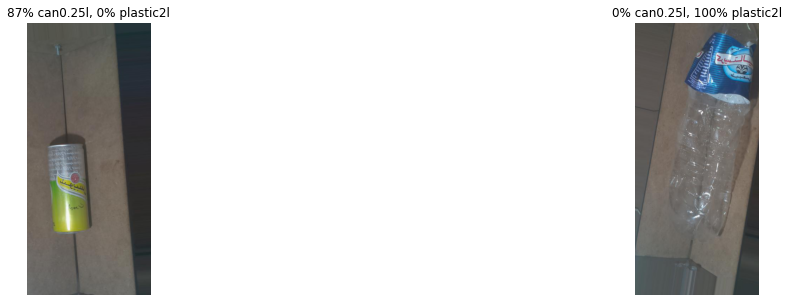

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% can0.25l, {:.0f}% plastic2l".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,5]))
    

    ax.imshow(img)